Plotting letter frequencies based on their position in words.
--------

Over at http://www.prooffreader.com/2014/05/graphing-distribution-of-english.html we can see some graphs showing "Distribution of EngLish letters toward beginning, middle and end of words" that use the Brown Corpus.  His code is here http://nbviewer.ipython.org/github/Prooffreader/word_list_tools/blob/master/letter_distributions.ipynb but I did not read it before creating most of the code below.  

I wanted to recreate the graphs in my own way in an ipython notebook.  It turned out to be relatively straightforward and you can see the code below.  The brown corpus must be a large dataset as I didn't need any acceleration structures for a single book and it was not hard to just keep a map where every normalized position of every letter was tracked.

As a bonus, we can now do comparative histogramming.  In the blog post, David Taylor says "I used a corpus rather than a dictionary so that the visualization would be weighted towards true usage."  Well, how different is it?  Follow along to see the answer below...

_NOTE: I found this notebook in my gists from July, 2014 at https://gist.github.com/rogerallen/d33a145951e242a0d5af#file-letterfrequencies-ipynb and brought it here with some updates in February, 2018._


In [70]:
%matplotlib inline
import matplotlib.pyplot as plt
from collections import defaultdict
import re
import string
from math import floor, ceil,sqrt
import numpy as np

MIN_WORD_LENGTH = 4 # skip he, she, the ...
NUM_BINS = 11
nonalpha_pattern = re.compile('[\W_]+')
digit_pattern = re.compile('[\d]+')

def parse_word(freqs,w):
    """For each letter inside word w, find its normalized position 
    and update the list inside freqs."""
    #word = w.strip()
    word = nonalpha_pattern.sub('', w) # remove non-alphanum chars
    word = digit_pattern.sub('', word)    # remove numerals
    word_max_index = float(len(word)) - 1
    if len(word) < MIN_WORD_LENGTH:
        return freqs
    for i,c in enumerate(word):
        letter = c.lower()
        try:
            normalized_position = i/word_max_index
        except ZeroDivisionError:
            normalized_position = 0.0 # single-letter position
        freqs[letter].append(normalized_position)
    return freqs

def parse_dictionary():
    freqs = defaultdict(list)
    with open("/usr/share/dict/words","r") as f:
        for l in f:
            l = l.strip()
            if l.endswith("'s"):
                continue # linux dictionary has possessives.  Skip 'em
            parse_word(freqs,l)
    return freqs
            
def parse_book(filename):
    freqs = defaultdict(list)
    with open(filename,'r') as f:
        for l in f:
            for w in l.split():
                parse_word(freqs,w)
    return freqs

def get_counts(freqs):
    "return reverse-sorted list of count,letter tuples"
    counts = []
    for letter in sorted(freqs.keys()):
        counts.append( (len(freqs[letter]),letter) )
    return reversed(sorted(counts))

def plot_histogram_grid(freqs,letters,maxy=None):
    cnt = len(letters)
    cols = floor(sqrt(cnt))
    rows = ceil(cnt/cols)
    # swap?
    rows,cols = cols,rows
    fig = plt.figure(figsize=(4*cols,3*rows))
    for i in range(len(letters)):
        letter = letters[i]
        ax = fig.add_subplot(rows,cols,i+1)
        n, bins, patches = ax.hist(freqs[letter],NUM_BINS,histtype="bar")
        ax.set_xticks([])
        if i == len(letters)-1:
            ax.set_xlabel("Normalized Position")
            ax.set_ylabel("Counts")
        if maxy:
            ax.set_ylim([0,maxy])
        ax.set_title("%s"%letter)
    plt.show()

Dictionary
----

First, we using the built-in dictionary of words on Mac or Linux as input.

In [71]:
freqs = parse_dictionary()

In [72]:
len(freqs['a']), len(freqs['z']) # this many mentions of these letters

(46308, 2522)

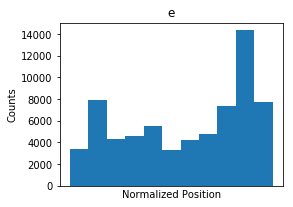

In [73]:
plot_histogram_grid(freqs,'e') # where is 'e' used?

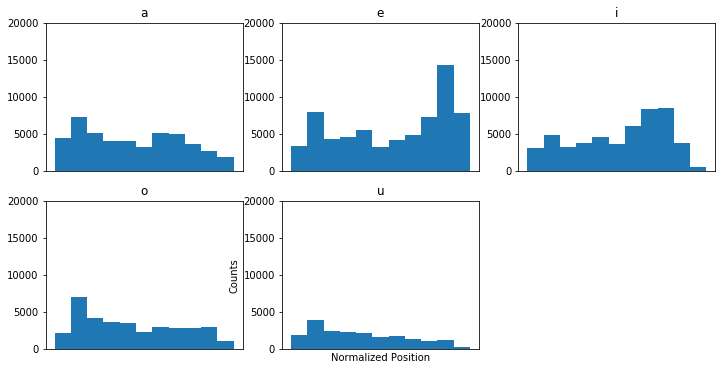

In [74]:
# let's just look at the vowels
plot_histogram_grid(freqs,'aeiou',20000) # scaled for my linux dictionary

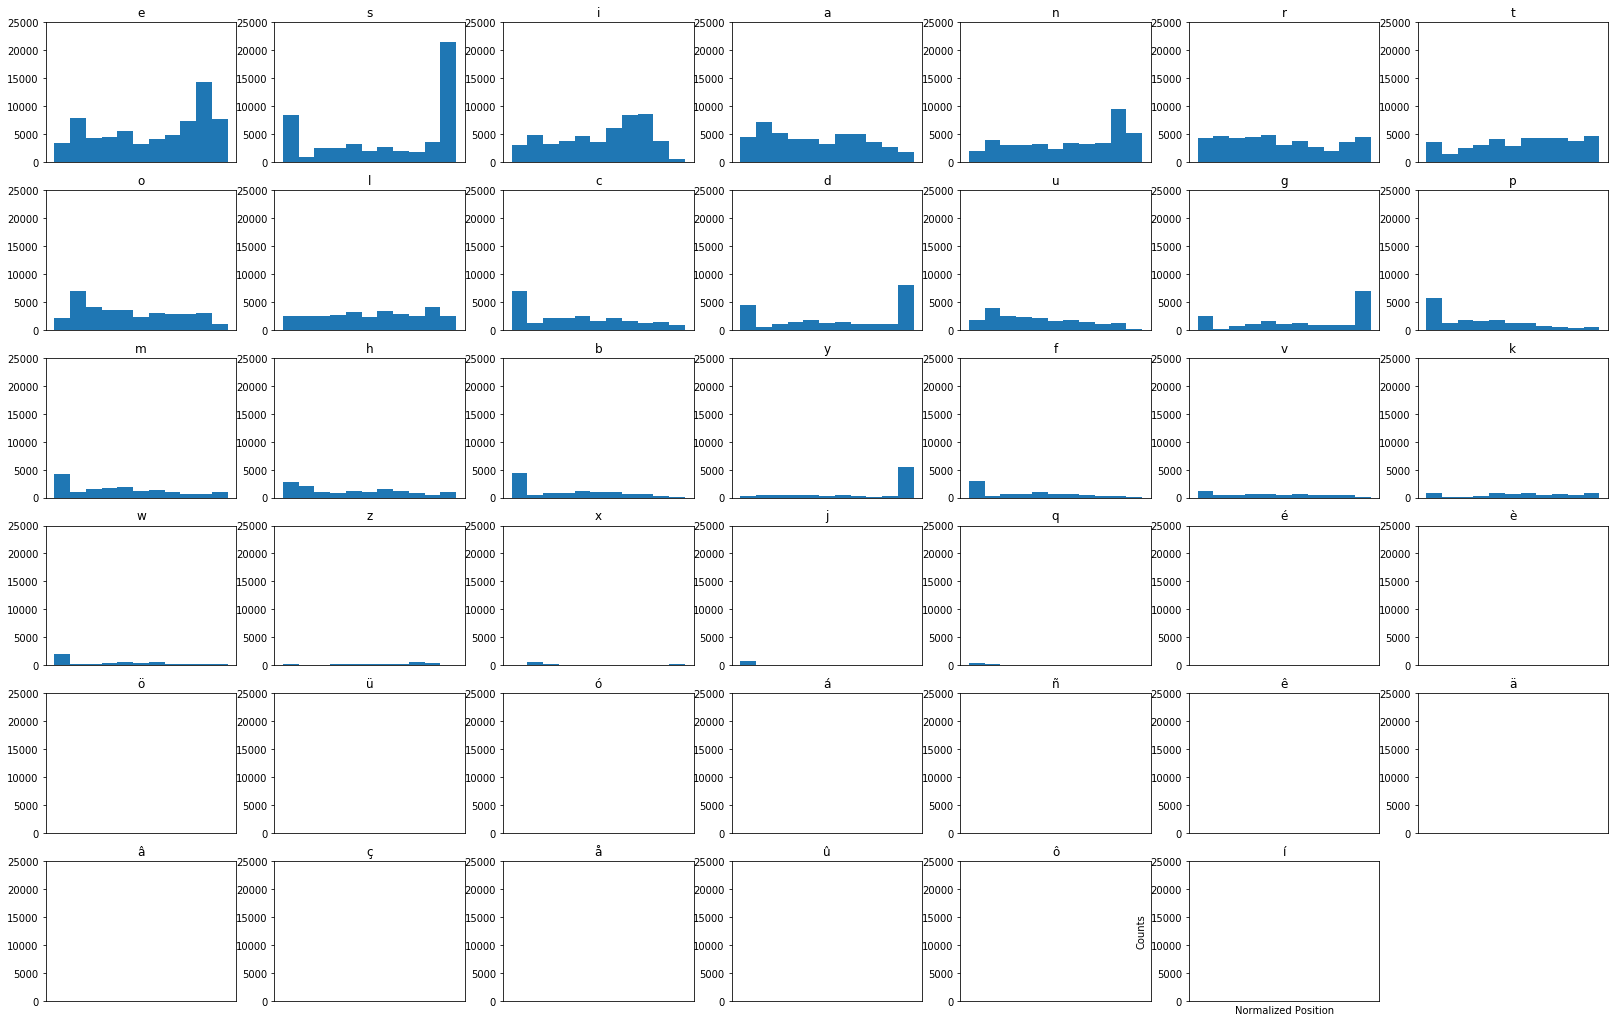

In [78]:
# now create an ordered grid of usage.  E is used most often, then S, then I, etc.
plot_histogram_grid(freqs,[l[1] for l in get_counts(freqs)],25000)

Moby Dick
-----

Next, I downloaded Moby Dick from http://www.gutenberg.org/ebooks/2701 and stripped off the prefix and postfix text, leaving just the novel.

We parse and show a similar set of graphs as above.

In [79]:
moby = parse_book("data/moby_dick.txt")

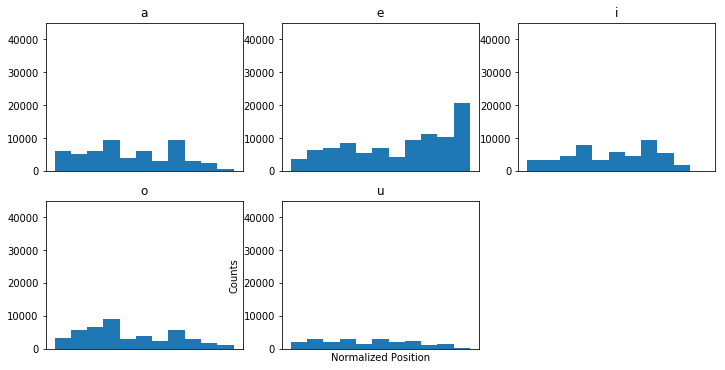

In [80]:
plot_histogram_grid(moby,'aeiou',45000)

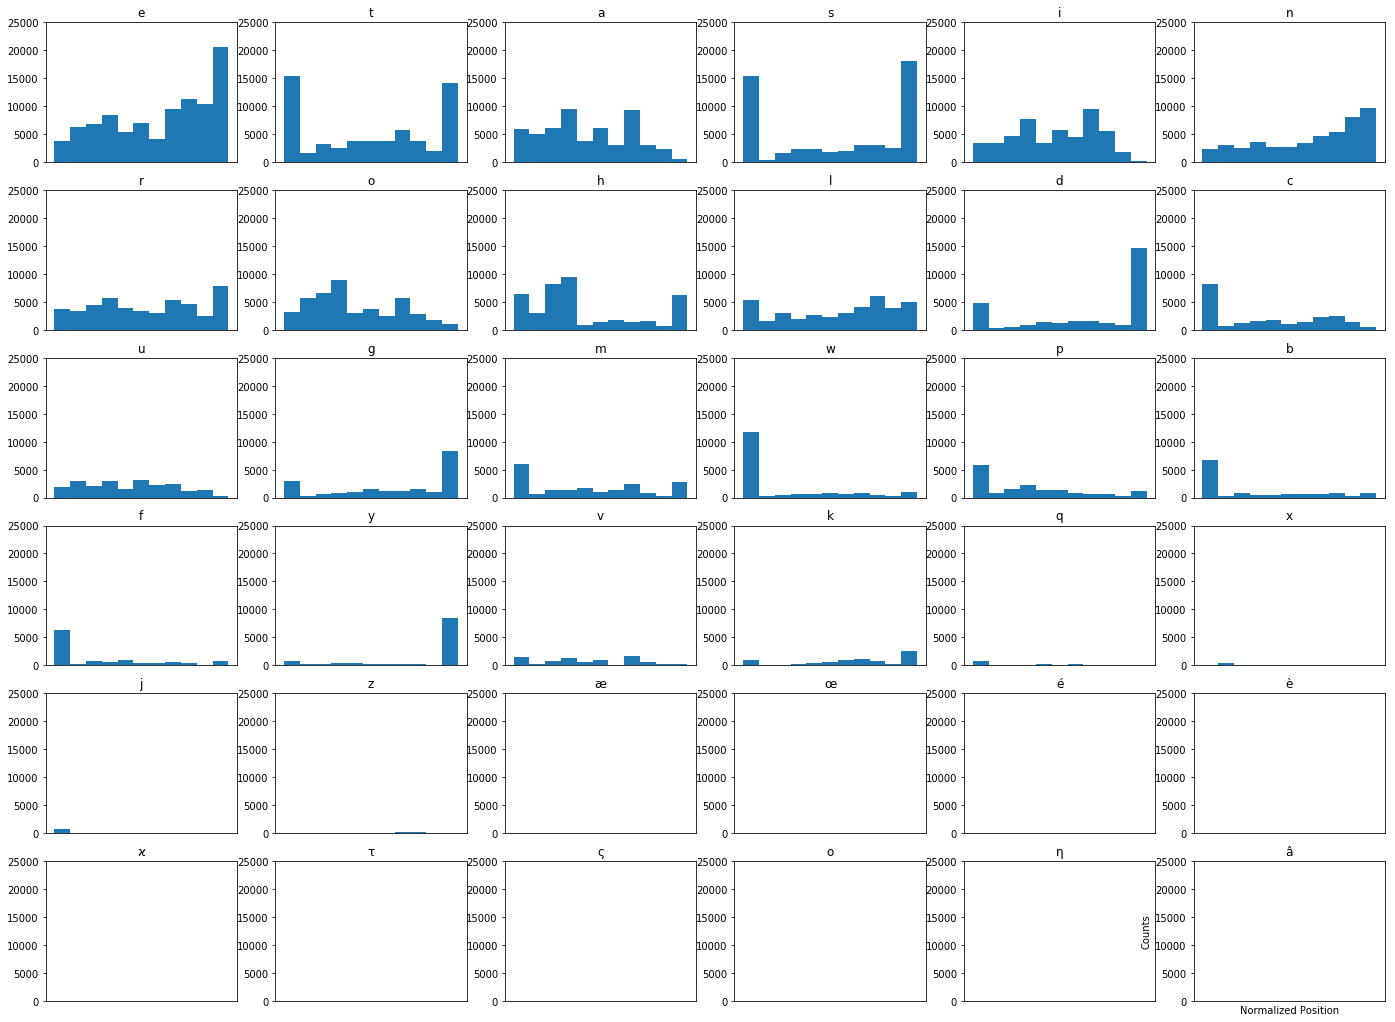

In [82]:
plot_histogram_grid(moby,[l[1] for l in get_counts(moby)],25000)

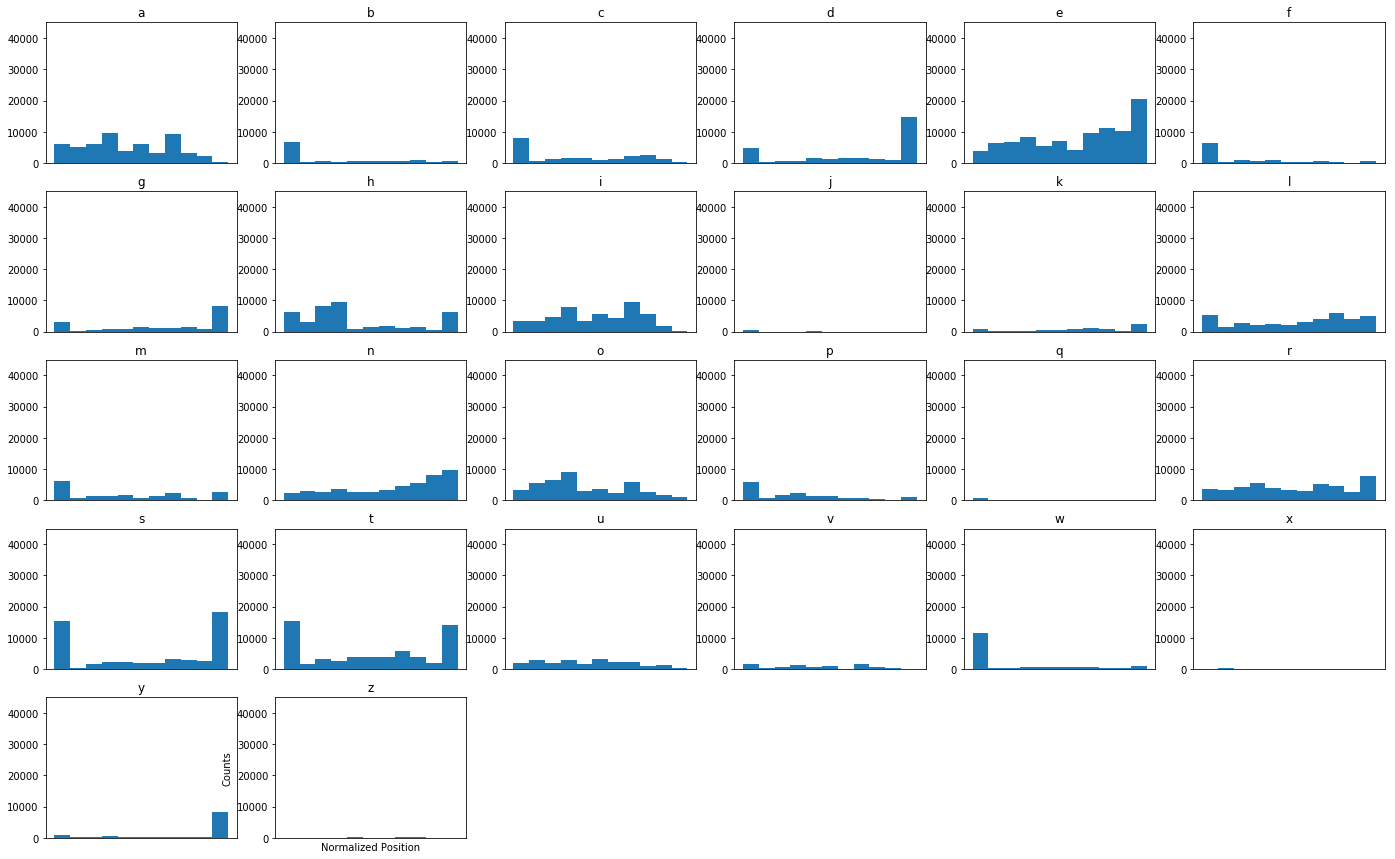

In [83]:
plot_histogram_grid(moby,string.ascii_lowercase,45000)

Comparative Histograms
------

Now let's put the two histograms next to each other to compare.  There are some interesting differences (e.g. "a") and some interesting similarities (e.g. "e") that you can see below.

In [87]:
mfreqs = defaultdict(list)
for k in string.ascii_lowercase:
    mfreqs[k] = [freqs[k],moby[k]]

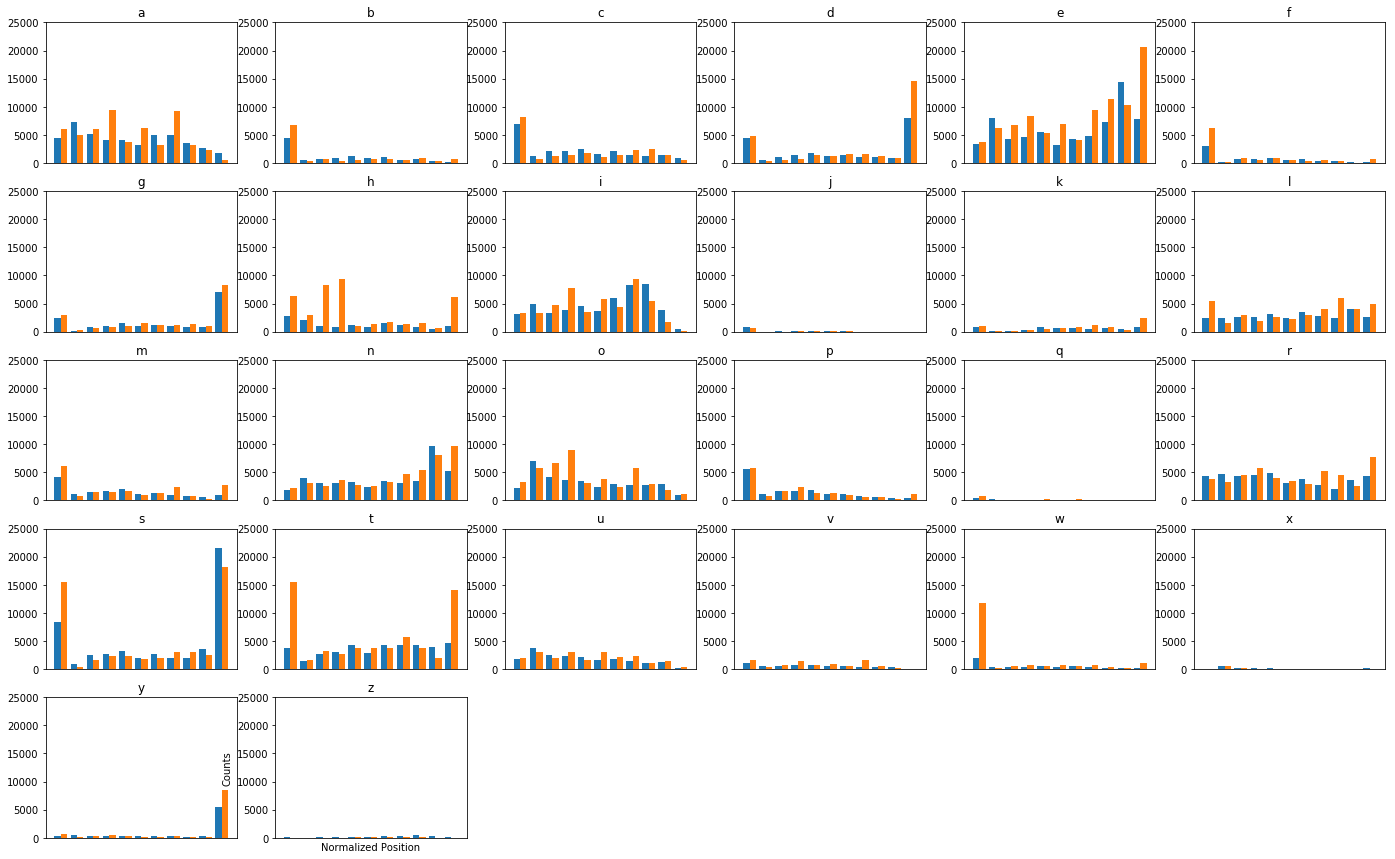

In [88]:
plot_histogram_grid(mfreqs,string.ascii_lowercase,25000)

Making things prettier
-------

The graphs above are not quite as pretty as the the graphs from proofreader.com.  This is where I wanted to look over his code and see how to make something that is more presentable, but without all the detailed axes as we have above. 


In [89]:
colors = [[0, '#ffffcc'],
          [0.1, '#ffeda0'],
          [0.5, '#fed976'],
          [1, '#feb24c'],
          [2, '#fd8d3c'],
          [3, '#fc4e2a'],
          [5, '#e31a1c'],
          [9, '#b10026']]

def plot_histogram_pretty(freqs,letters,in_maxy=None):
    freq_counts = get_counts(freqs)
    total_letters = sum([x[0] for x in freq_counts])
    cnt = len(letters)
    cols = int(floor(sqrt(cnt)))
    rows = int(ceil(float(cnt)/cols))
    #cols = 1
    #rows = cnt
    fig, ax = plt.subplots(rows, cols, figsize=(6*cols,rows*3))
    for i in range(rows*cols):
        ir = i//cols
        ic = i%cols
        if i >= len(letters):
            fig.delaxes(ax[ir][ic])
            continue
        letter = letters[i]
        n, bins = np.histogram(freqs[letter],NUM_BINS,(0.0,1.0))
        ax[ir][ic].plot(np.arange(NUM_BINS),n, color='k', linewidth = 3)
        if in_maxy == None:
            maxy = np.max(n)
        else:
            maxy = in_maxy
        color = ''
        for j in range(len(colors)):
            if 100.0*len(freqs[letter])/total_letters >= colors[j][0]:
             color = colors[j][1]
        ax[ir][ic].fill_between(np.arange(NUM_BINS), n, color=color, interpolate=True)
        ax[ir][ic].set_ylim(0,maxy)
        ax[ir][ic].set_xlim(0,NUM_BINS-1)
        ax[ir][ic].set_xticks([])
        ax[ir][ic].set_yticks([])
        ax[ir][ic].set_ylabel(letter+'       ', size=18, rotation='horizontal')
    plt.show()

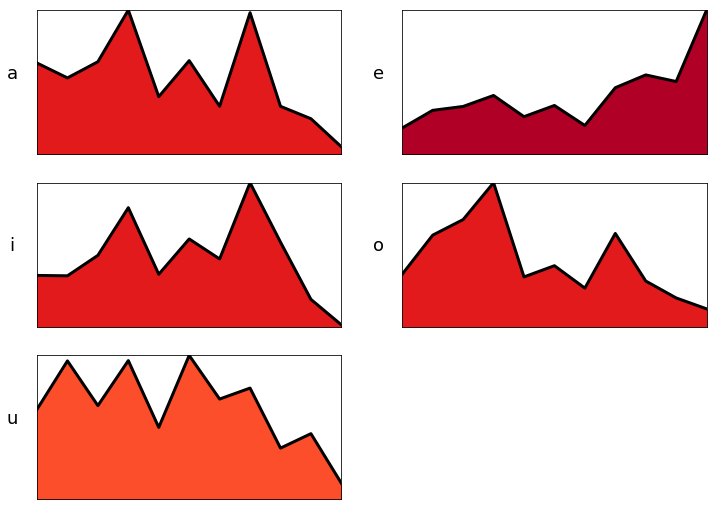

In [90]:
plot_histogram_pretty(moby,"aeiou")

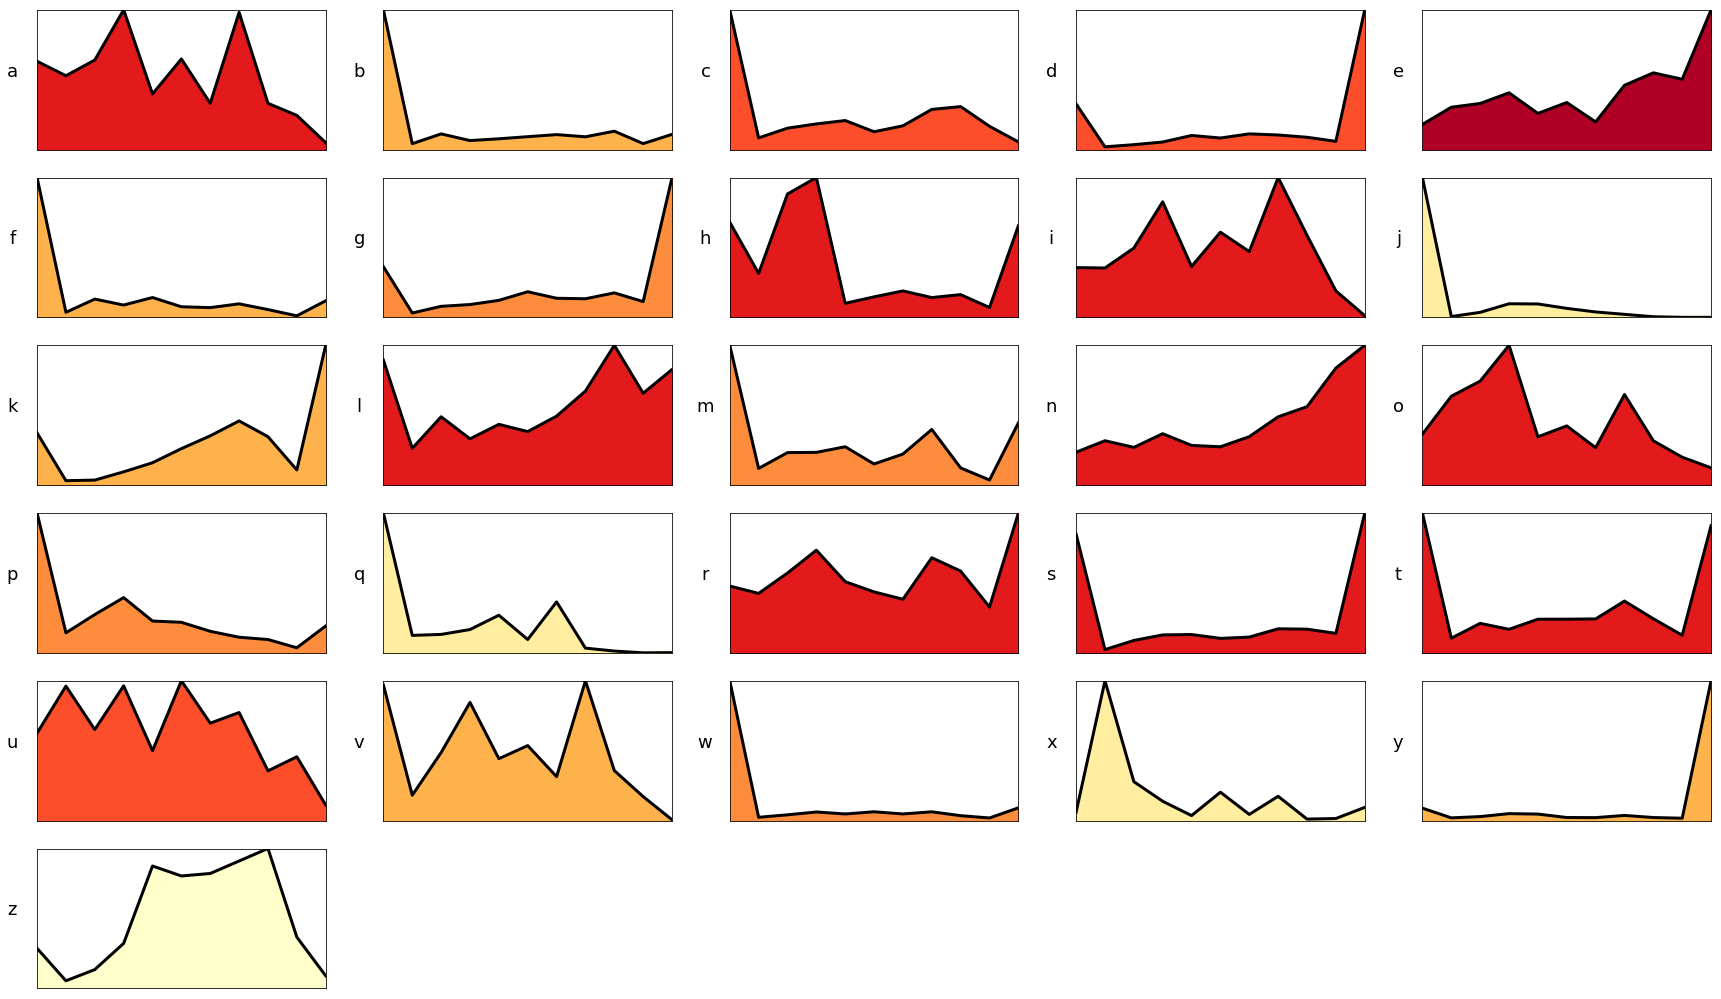

In [91]:
plot_histogram_pretty(moby,string.ascii_lowercase)

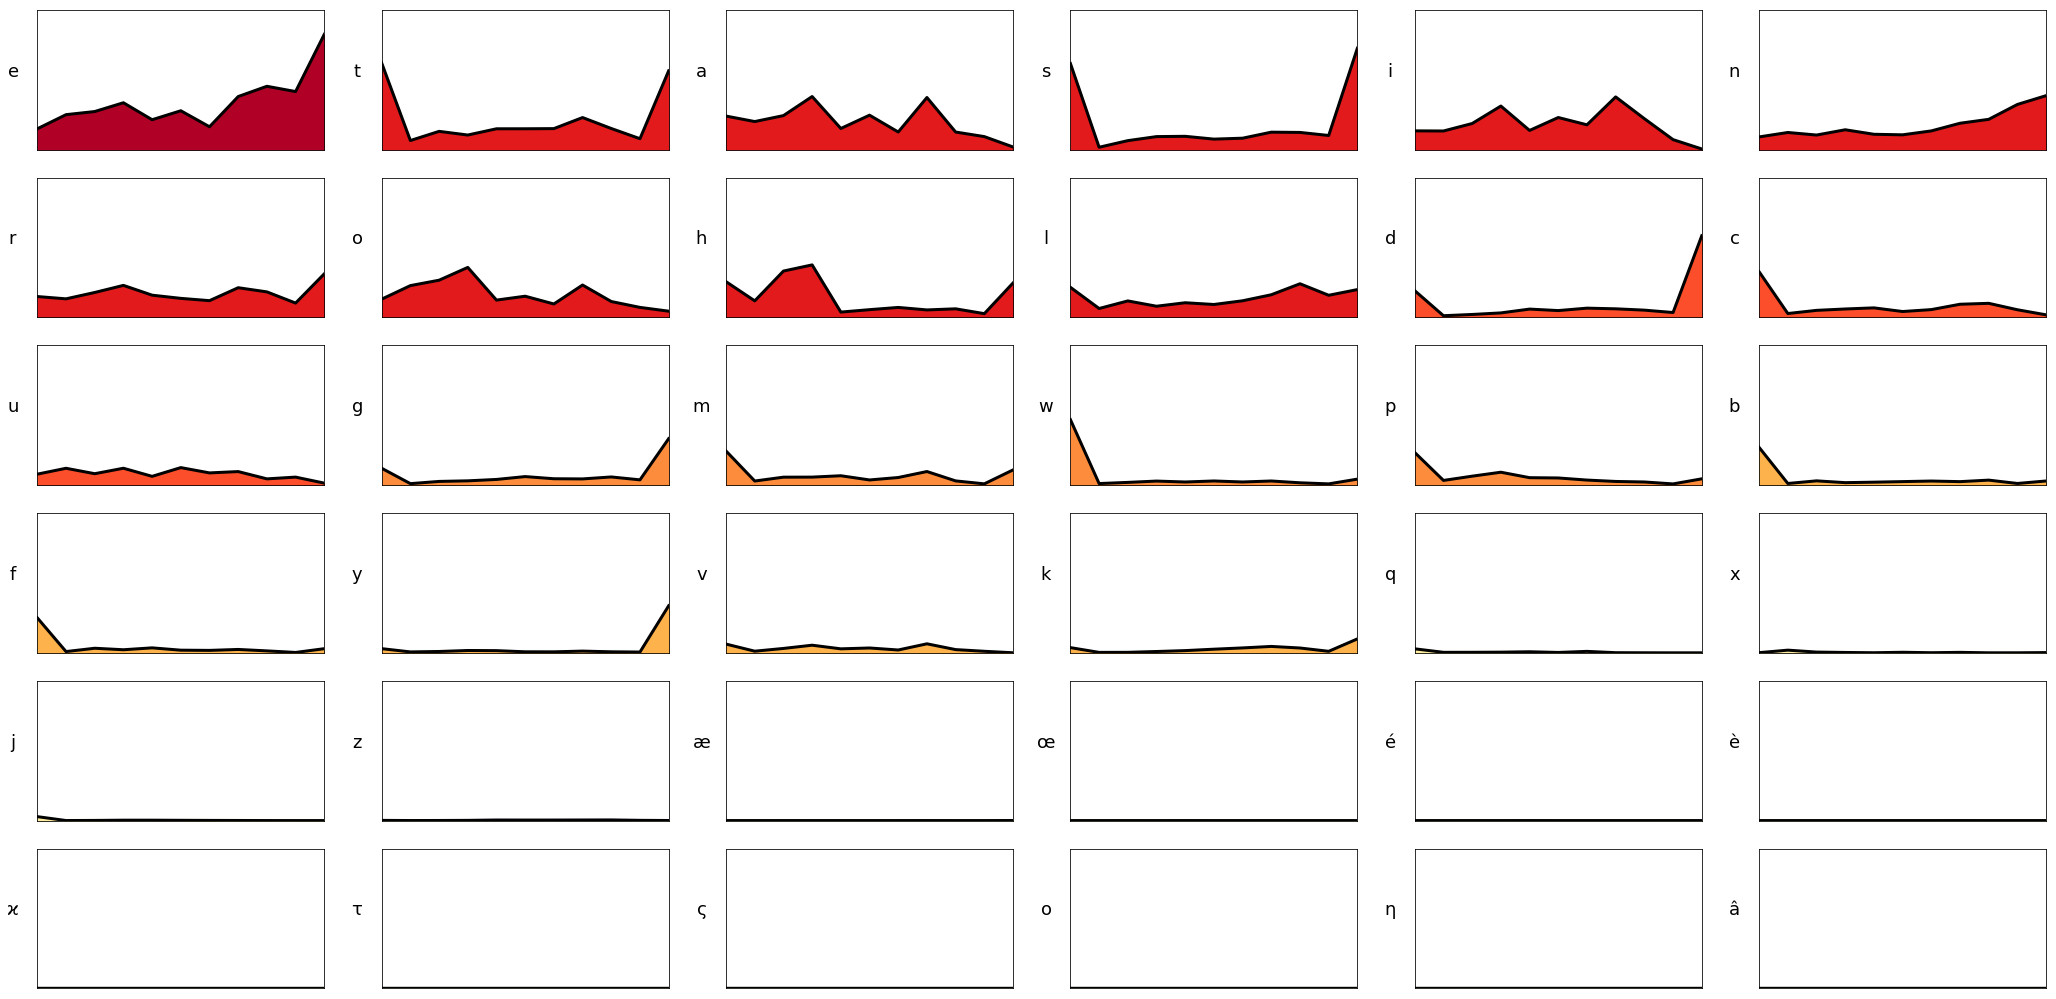

In [94]:
# does shading & auto-scaling work, or should we keep the y-limit the same for all graphs?  
# What do you think?
plot_histogram_pretty(moby,[l[1] for l in get_counts(moby)],25000)